<a href="https://colab.research.google.com/github/juanetoboneto/Diplomado_Ciencia_Datos/blob/main/An%C3%A1lisis_y_Predicci%C3%B3n_de_Precios_de_Etherium_mediante_Modelos_de_Series_de_Tiempo/Pron_ostico_de_los_Precios_de_Etherium_Mediante_Modelos_de_Series_de_Tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Pre-Procesamiento de Datos

En la exploración anterior no logramos obtener un modelo de pronóstico para nuestra serie de tiempo, esto se puede deber a que la cantidad de valores dichos datos es muy pequeña, asi que esta vez probaremos trabajando con una cantidad de datos algo mayor. Además, compararemos dicha serie de tiempo con los datos historicos de Bitcoin.

Antes que nada, notamos que es más conveniente importar en conjunto todos los paquetes necesarior para el trabajo:

In [ ]:
# Instalemos los paquetes no pre-establecidos:
!pip install darts

# Importemos todos los paquetes que necesitamos:

# Paquetes estructurales para el trabajo:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

# paquete necesarios para el Pre-prosesamiento:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing.pipeline import Pipeline
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf

# Paquetes de Darts fundamentales para trabajar Series de Tiempo:
from darts.models import AutoARIMA, NBEATSModel, BlockRNNModel
from darts.metrics import mape

# Paquetes de PyTorch para los modelos de Redes neuronales:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.regression import MeanAbsolutePercentageError

Estos datos estan descargados de manera local, se tratan de datos establecidos por dias que van desde el origen de **Etherium** y **Bitcoin** respectivamente, esta posee $3$ variables medidas todas en Dolares Estadounidenses (USD), *Precio* de esa criptomoneda al cierre de ese día, *Capitalización* que es igual al precio por acción en un momento dado multiplicado por la cantidad total de criptomonedas y el *Volumen* que es la cantidad total de transacciones que los comerciantes realizaron durante un período en específico (en nuestro caso diario).

En nuestro caso particular, tomaremos los dato que van desde $10$ de Agosto de $2015$ hasta el $05$ de septiembre de $2023$, con una frecuencia temporal **Diaria**; realicemos el pre-procesamiento de esta Serie de tiempo:

In [ ]:
# Extraigamos los datos de formatos csv de Github:
Etherium = pd.read_csv("https://raw.githubusercontent.com/juanetoboneto/Diplomado_Ciencia_Datos/main/An%C3%A1lisis_y_Predicci%C3%B3n_de_Precios_de_Etherium_mediante_Modelos_de_Series_de_Tiempo/Data_Sets/eth-usd-max.csv")
Bitcoin = pd.read_csv("https://raw.githubusercontent.com/juanetoboneto/Diplomado_Ciencia_Datos/main/An%C3%A1lisis_y_Predicci%C3%B3n_de_Precios_de_Etherium_mediante_Modelos_de_Series_de_Tiempo/Data_Sets/btc-usd-max.csv")

# Cambiando los nombres de las variables:
Etherium = Etherium.rename(columns={'snapped_at': 'Fecha', 'price': 'Precio', 'market_cap': 'Capitalizacion', 'total_volume': 'Volumen'})
Bitcoin = Bitcoin.rename(columns={'snapped_at': 'Fecha', 'price': 'Precio', 'market_cap': 'Capitalizacion', 'total_volume': 'Volumen'})

# Extraigamos los datos del rango que deseamos estudiar:
Etherium = Etherium[(Etherium.index >= 2) & (Etherium.index <= 2951)]
Bitcoin = Bitcoin[(Bitcoin.index >=832) & (Bitcoin.index <= 3781)]

# Creemos una Variable de Tiempo con frecuencia Diaria que se ajuste a las fechas:
fecha = pd.date_range(start=Etherium['Fecha'].min(), end=Etherium['Fecha'].max(), freq='D')

# Reemplacemos el Index de nuestros datos de Etherium y Bitcoin por estas 'fechas':
Etherium.index = fecha
Bitcoin.index = fecha

# Eliminemos la variable redundante:
Etherium = Etherium.drop(['Fecha'], axis=1)
Bitcoin = Bitcoin.drop(['Fecha'], axis=1)

# Verifiquemos ahora, como son nuestros DataFrames:
print(Etherium)
print(Bitcoin)

                                Precio  Capitalizacion       Volumen
2015-08-10 00:00:00+00:00     0.687586    4.155631e+07  4.004641e+05
2015-08-11 00:00:00+00:00     1.067379    6.453901e+07  1.518998e+06
2015-08-12 00:00:00+00:00     1.256613    7.601326e+07  2.073893e+06
2015-08-13 00:00:00+00:00     1.825395    1.104688e+08  4.380143e+06
2015-08-14 00:00:00+00:00     1.825975    1.105553e+08  4.355618e+06
...                                ...             ...           ...
2023-09-01 00:00:00+00:00  1645.181525    1.978038e+11  1.127951e+10
2023-09-02 00:00:00+00:00  1630.605890    1.960043e+11  9.227779e+09
2023-09-03 00:00:00+00:00  1636.162199    1.967401e+11  3.262522e+09
2023-09-04 00:00:00+00:00  1635.403043    1.966123e+11  4.542395e+09
2023-09-05 00:00:00+00:00  1630.627547    1.957250e+11  5.906287e+09

[2949 rows x 3 columns]
                                 Precio  Capitalizacion       Volumen
2015-08-10 00:00:00+00:00    263.578200    3.817350e+09  6.078329e+07
2015-08

Aunque pueden parecer los mismos datos, la máquina no necesariamente los iba a interpretar igual (debido a que no habia establecido una frecuancia diaria D). Ahora debemos transformar estos datos en Series de Tiempo dentro del paquete *Darts*. Antes de eso, realicemos una gráfica para comparar la variable *Precio* de nuetras series de tiempo:

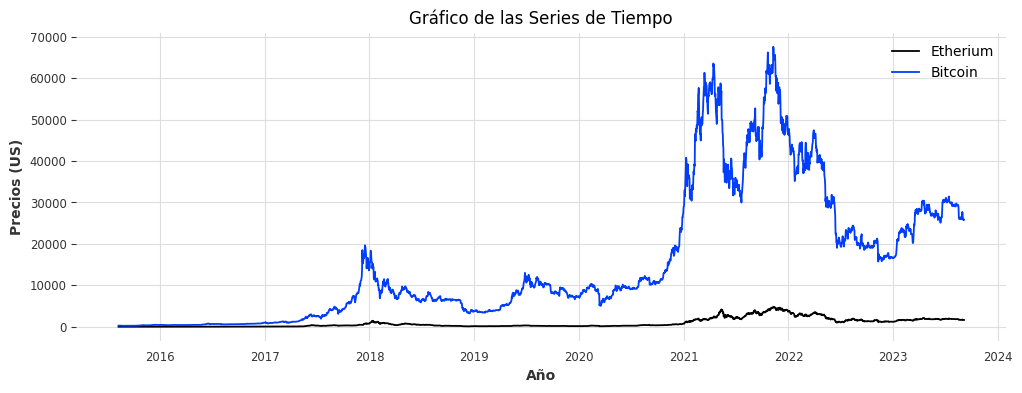

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(Etherium.index, Etherium['Precio'], label='Etherium')
plt.plot(Bitcoin.index, Bitcoin['Precio'], label='Bitcoin')

plt.xlabel('Año')
plt.ylabel('Precios (US)')

plt.title('Gráfico de las Series de Tiempo')
plt.legend()
plt.grid(True)
plt.show()

## 1.1 Arreglando Nuestros Datos:
Como se puede ver en la gráfica anterior, para realmente poder comparar los datos de mercado de Etherium con los de Bitcoin debemos ajustarlos a ambos a la misma escala, eliminar cualquier sesgo de tendencia o desviación; para ello, utilizaremos un proceso de escalado y rellenando posibles valores faltantes:

In [ ]:
# Transformemos dichos DataFrames en series de tiempo:
TS_ETH = TimeSeries.from_dataframe(Etherium, freq='D')
TS_BTC = TimeSeries.from_dataframe(Bitcoin, freq='D')

# Construyamos una serie de instrucciones pipline, para rellenar y escalar las Series:
pipeline = Pipeline([MissingValuesFiller(), Scaler()])

# Procesemos las series de tiempo:
TSP_ETH = pipeline.fit_transform(TS_ETH)
TSP_BTC = pipeline.fit_transform(TS_BTC)

# Por último separemos los datos de Entrenamiento y validación:
ETH_ENT, ETH_VAL = TSP_ETH.split_before(pd.Timestamp('20230528'))
BTC_ENT, BTC_VAL = TSP_BTC.split_before(pd.Timestamp('20230528'))

Podremos verificar la utilidad de este pre-procesamiento para estandarizar y normalizar los datos de manera gráfica, comparando los precios ya transformados de Etherium y Bitcoin:

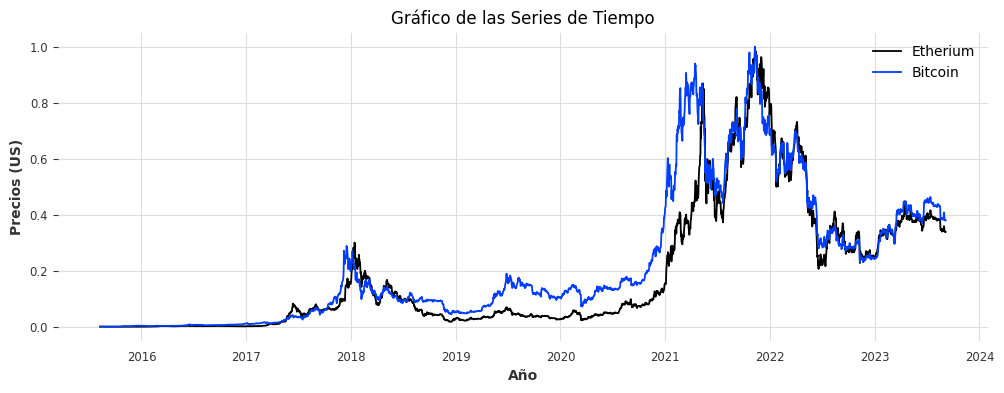

In [ ]:
# Podremos Gráficar estos datos como sigue:
GRA_ETH = TSP_ETH.pd_dataframe()
GRA_BTC = TSP_BTC.pd_dataframe()

plt.figure(figsize=(12, 4))

plt.plot(GRA_ETH.index, GRA_ETH['Precio'], label='Etherium')
plt.plot(GRA_BTC.index, GRA_BTC['Precio'], label='Bitcoin')


plt.xlabel('Año')
plt.ylabel('Precios (US)')

plt.title('Gráfico de las Series de Tiempo')
plt.legend()
plt.grid(True)
plt.show()

## 1.2 Estacionalidad y Pruebas de Autocorrelación:
Realicemos las gráficas de **ACF** y **PACF** para verificar si nos es útil aplicar modelos clásicos, además de verificar la similitud entre los datos de **Etherium** y **Bitcoin**; empecemos por determinar la *Periocidad* de ambos:

In [ ]:
# Estudiemos la estacionalidad de la serie completa de Etherium:
print('Estacionalidad Los Datos de Etherium:')
for m in range(2, 25):
    is_seasonal, period = check_seasonality(TSP_ETH['Precio'], m=m, alpha=0.05)
    if is_seasonal:
        print("Hay estacionalidad de orden {}.".format(period))
if not is_seasonal:
              print('No se encontro Periocidad')

Estacionalidad Los Datos de Etherium:
No se encontro Periocidad


Por lo que la Serie de Etherium no posee *Estacionalidad*. Tal vez tengamos la Esperanza de hallar algún tipo de Periocidad para Bitcoin, intentemoslo:

In [ ]:
# Estudiemos la estacionalidad de la serie completa de Bitcoin:
print('Estacionalidad Los Datos Completos de Bitcoin:')
for m in range(2, 25):
    is_seasonal, period = check_seasonality(TS_BTC['Precio'], m=m, alpha=0.05)
    if is_seasonal:
        print("Hay estacionalidad de orden {}.".format(period))
if not is_seasonal:
              print('No se encontro Periocidad')

Estacionalidad Los Datos Completos de Bitcoin:
No se encontro Periocidad


Por lo que ninguna de estas series posee algún tipo de Estacionalidad. Aun más, si intentamos realizar las gráficas **ACF** e **PACF** veremos que realmente no se obtiene ninguna información útil para nuestro estudio, como se muestra acontinuacion con las gráficas ACF.

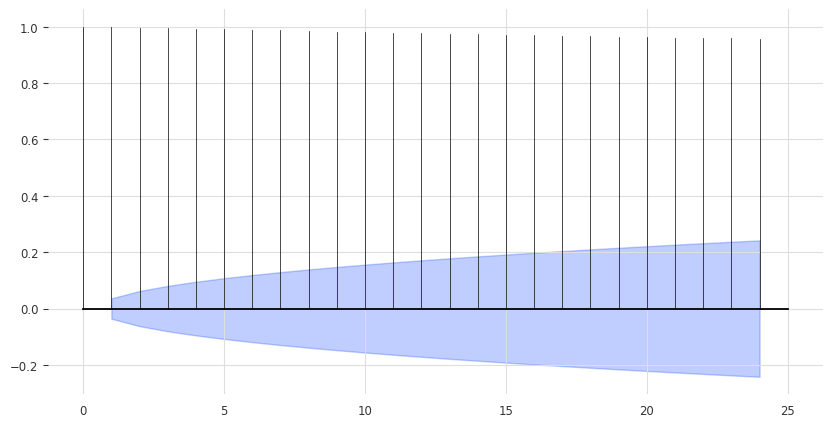

In [ ]:
plot_acf(TSP_ETH['Precio'])

## 1.3 Correlación entre las Series de Tiempo:
Podemos pensar en utilizar los valores de una Serie de Tiempo para mejorar nuestros modelos de pronóstico, más especificamente; queremos utilizar los datos de entrenamiento de **Bitcoin** como *Covariables Pasadas* para construir un modelo de pronóstico para los precios de **Etherium**.

Para por hacer aquello, tendremos que determinar que tanto se correlacionan dichos datos:

In [ ]:
# Para utilizar la función de correlación de NumPy, debemos transformar nuestras series de tiempo en arrays:
Numpy_ETH = np.array(GRA_ETH['Precio'].values)
Numpy_BTC = np.array(GRA_BTC['Precio'].values)

# Utilicemos la función correlación de Numpy para determinar su correlación:
correlacion = np.corrcoef(Numpy_ETH, Numpy_BTC)[0, 1]

print("La correlación entre los precios de Bitcoin y Etherium es:{}".format(round(correlacion, 4)))

La correlación entre los precios de Bitcoin y Etherium es:0.9395


# 2. Construyendo Modelos de Pronóstico:

## 2.1 Modelo Exploratorio Auto-ARIMA:

El modelo ARIMA, tambien llamado Modelo Auto Regresivo Integrado de Media Movil combina componentes de autoregresión (AR), promedio móvil (MA) y diferenciación (I) para capturar tanto la dependencia en el tiempo como la estacionalidad presente en los datos.

El algoritmo AutoARIMA permite realizar un ajuste de modelo ARIMA de manera automatica.

In [ ]:
#Usemos el método predefinido de Darts AutoARIMA:
modelo_arima = AutoARIMA()

#Ajustemos el modelo a nuestros datos de Entrenamiento:
modelo_arima.fit(ETH_ENT['Precio'])

#Realicemos los Pronoscticos para compararlos con nuestros datos de Valoración:
prediccion_arima = modelo_arima.predict(100)

#Ahora determinemos el error con respecto a la valoración usando MAPE:
print("El MAPE es: {:.2f}".format(mape(ETH_VAL['Precio'], prediccion_arima)))

El MAPE es: 4.24


Podremos entonces Gráficar la comparación entre este modelo y nuestros valores de pureba:

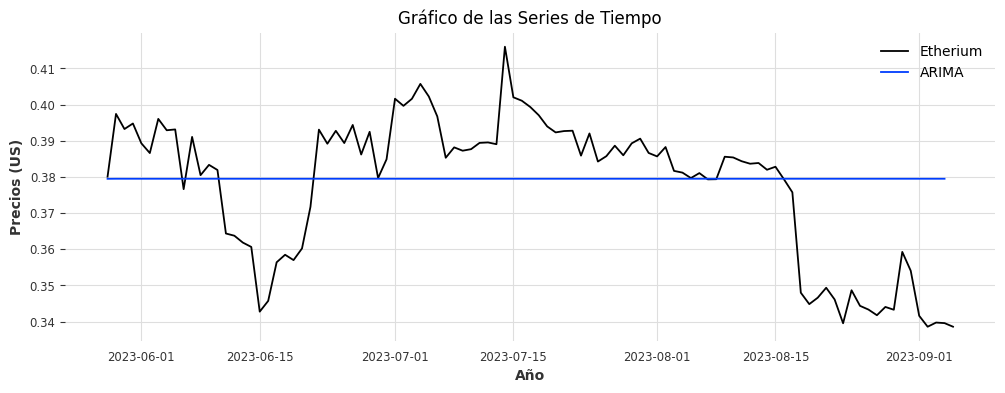

In [ ]:
GRA_ETH_VAL = ETH_VAL.pd_dataframe()
GRA_ARIMA = prediccion_arima.pd_dataframe()

plt.figure(figsize=(12, 4))

plt.plot(GRA_ETH_VAL.index, GRA_ETH_VAL['Precio'], label='Etherium')
plt.plot(GRA_ARIMA.index, GRA_ARIMA['Precio'], label='ARIMA')

plt.xlabel('Año')
plt.ylabel('Precios (US)')

plt.title('Gráfico de las Series de Tiempo')
plt.legend()
plt.grid(True)
plt.show()

## 2.2. Prueba de Modelo N-BEATS:
Tambien conocido como Análisis de expansión de base neuronal para pronóstico de series temporales, que funciona atravez de bloques, veamos como se comporta:

In [ ]:
nbeats = NBEATSModel(
    input_chunk_length=30, # De entre las entradas que prove [7,31,20,30,50,60,65,100] este parece ser el mejor
    output_chunk_length=100,
    activation = "Sigmoid",
    torch_metrics=MeanAbsolutePercentageError(),
    optimizer_kwargs={"lr": 1e-3},
    n_epochs=125, # Aparentemente el número de repeticiones optimas esta entre 100 y 150
    log_tensorboard=True,
    nr_epochs_val_period= 10,
    model_name="n-beats",
    force_reset=True,
    random_state=42
 )

In [ ]:
# Ajustemos el modelo a nuestros datos y usemos los precios de Bitcoin durante el mismo periodo como covariantes pasadas:
modelo_nbeats = nbeats.fit(ETH_ENT) # No es util usar BTC_ENT como past_covariates sin más pues por un sesgo exógeno estos datos estan desfasados

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.8 M 
---------------------------------------------------
6.8 M     Trainable params
1.8 K     Non-trainable params
6.8 M     Total params
27.070    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=125` reached.


In [ ]:
# Realicemos los correspondientes pronósticos:
prediccion_nbeats = modelo_nbeats.predict(100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
# Calculemos el MAPE:
print("El MAPE del modelo N-BEATS es: {:.2f}".format(mape(ETH_VAL, prediccion_nbeats)))

El MAPE del modelo N-BEATS es: 41.49


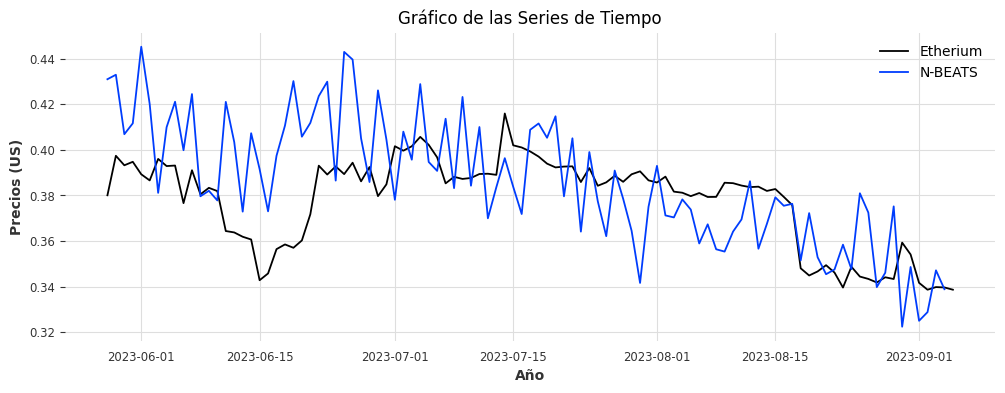

In [ ]:
GRA_NBEATS = prediccion_nbeats.pd_dataframe()

plt.figure(figsize=(12, 4))

plt.plot(GRA_ETH_VAL.index, GRA_ETH_VAL['Precio'], label='Etherium')
plt.plot(GRA_NBEATS.index, GRA_NBEATS['Precio'], label='N-BEATS')

plt.xlabel('Año')
plt.ylabel('Precios (US)')

plt.title('Gráfico de las Series de Tiempo')
plt.legend()
plt.grid(True)
plt.show()

## Modelo RNN a Bloques:
Probemos si este modelo posee un MAPE menor o almenos se ajusta mejor a los datos:

In [ ]:
#Entrenamiento de Red Neuronal Recurrente en Bloques:
modelo_bloques = BlockRNNModel(
     input_chunk_length=30,
     output_chunk_length=100,
     model='GRU',
     hidden_dim=25,
     n_rnn_layers=1,
     dropout=0.1,
     torch_metrics=MeanAbsolutePercentageError(),
     optimizer_kwargs={"lr": 1e-3},
     n_epochs=120,
     model_name="RNN_Bloques",
     log_tensorboard=True,
     nr_epochs_val_period=10,
     force_reset=True,
     random_state=42,
     show_warnings=True
)

In [ ]:
modelo_bloques.fit(ETH_ENT)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rn

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=120` reached.


BlockRNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.1, input_chunk_length=30, output_chunk_length=100, torch_metrics=MeanAbsolutePercentageError(), optimizer_kwargs={'lr': 0.001}, n_epochs=120, model_name=RNN_Bloques, log_tensorboard=True, nr_epochs_val_period=10, force_reset=True, random_state=42, show_warnings=True)

In [ ]:
prediccion_bloques = modelo_bloques.predict(100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
print("El MAPE del modelo RNN a bloques es: {:.2f}".format(mape(ETH_VAL, prediccion_bloques)))

El MAPE del modelo RNN a bloques es: 40.06


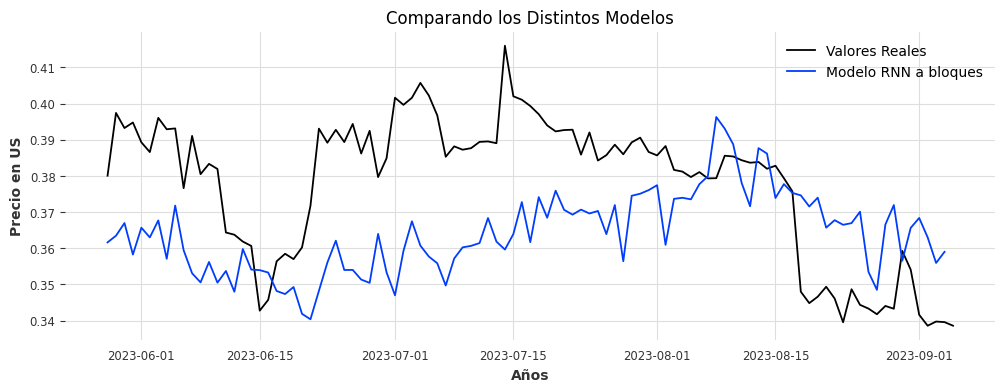

In [ ]:
BLO_GRA = prediccion_bloques.pd_dataframe()

# Utilizando MatPlotLib para graficar nuestras predicciones, con subplot():
plt.figure(figsize=(12, 4))

plt.plot(GRA_ETH_VAL.index, GRA_ETH_VAL['Precio'], label='Valores Reales')
plt.plot(BLO_GRA.index, BLO_GRA['Precio'], label = 'Modelo RNN a bloques')
plt.plot()


plt.ylabel('Precio en US')
plt.xlabel('Años')
plt.title('Comparando los Distintos Modelos')
plt.legend()


plt.grid(True)
plt.show()